In [1]:
import geopandas
from shapely import geometry
import matplotlib.pyplot as plt
from scipy.spatial import (
    Voronoi,
    voronoi_plot_2d,
    Delaunay,
    delaunay_plot_2d,
    cKDTree
)
import numpy as np
import math, time
import interpolators

mode = "raw"

def getMeasurementValue(value):
    if math.isnan(value):
        return 0

    if mode == "raw":
        return value

    if mode == "int":
        return int(value)

    zones = [[0, 20], [20, 40], [40, 60], [60, math.inf]]
    for i, zone in enumerate(zones):
        zoneMin, zoneMax = zone
        if value >= zoneMin and value < zoneMax:
            return zoneMin

def getPolygonsFromContour(contour):
    polygons = []
    for col in contour.collections:
        # Loop through all polygons that have the same intensity level
        for contour_path in col.get_paths():
            # Create the polygon for this intensity level
            # The first polygon in the path is the main one, the following ones are "holes"
            for idx, poly_coords in enumerate(contour_path.to_polygons()):
                x = poly_coords[:, 0]
                y = poly_coords[:, 1]

                new_shape = geometry.Polygon(
                    [(point[0], point[1]) for point in zip(x, y)]
                )
                if idx == 0:
                    poly = new_shape
                else:
                    # Remove the holes if there are any
                    poly = poly.difference(new_shape)
                    # Can also be left out if you want to include all rings

            polygons.append(poly)
    return polygons

external_crs = "EPSG:4326"
internal_crs = "EPSG:3068"
berlinDistricts = geopandas.read_file("../shared/berlinDistricts.geojson")
measurements = geopandas.read_file("data/data_2020-02-20T11-01-00.geojson")

berlinDistricts = berlinDistricts.to_crs(internal_crs)
measurements = measurements.to_crs(internal_crs)

x = np.array(measurements.geometry.x)
y = np.array(measurements.geometry.y)
values = np.array(measurements.value)
points = np.column_stack((x, y))

xmin, ymin, xmax, ymax = measurements.total_bounds
size = 500  # grid cell size in meters
xnew = np.linspace(xmin, xmax, int((xmax - xmin) / size))
ynew = np.linspace(ymin, ymax, int((ymax - ymin) / size))

In [ ]:
# Plot Berlin Boundaries with Measurements

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Measurements")
berlinPlot = berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
measurements.plot(ax=ax, column="value", legend=True)

In [ ]:
# Plot Berlin boundaries with interpolation grid

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Interpolation Grid")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
xx, yy = np.meshgrid(xnew,ynew)
ax.scatter(xx, yy, s=1)

In [ ]:
# Plot Berlin with Voronoi diagram

voronoi = Voronoi(points)

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Voronoi Diagram")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
voronoi_plot_2d(voronoi, ax=ax, show_vertices=False, show_points=True, line_colors='orange')

In [ ]:
# Plot Berlin with Delauny diagram

delauny = Delaunay(points)

fig, ax = plt.subplots()
ax.set_title("Berlin Districts with Delauny Diagram")
berlinDistricts.boundary.plot(ax=ax, edgecolor="black")
delaunay_plot_2d(delauny, ax=ax)

In [7]:
start = time.time()

interpolated_values = interpolators.linearBarycentricInterpolation(xnew, ynew, points, values)
# interpolated_values = interpolators.nearestNeighborInterpolator(xnew, ynew, points, values)
# interpolated_values = interpolators.inverse_distance_weighting(xnew, ynew, points, values, k=6)

# interpolated_values = np.array([list(map(getMeasurementValue, row)) for row in interpolated_values])

# print(interpolated_values)

end = time.time()
print(end - start)

0.01698899269104004


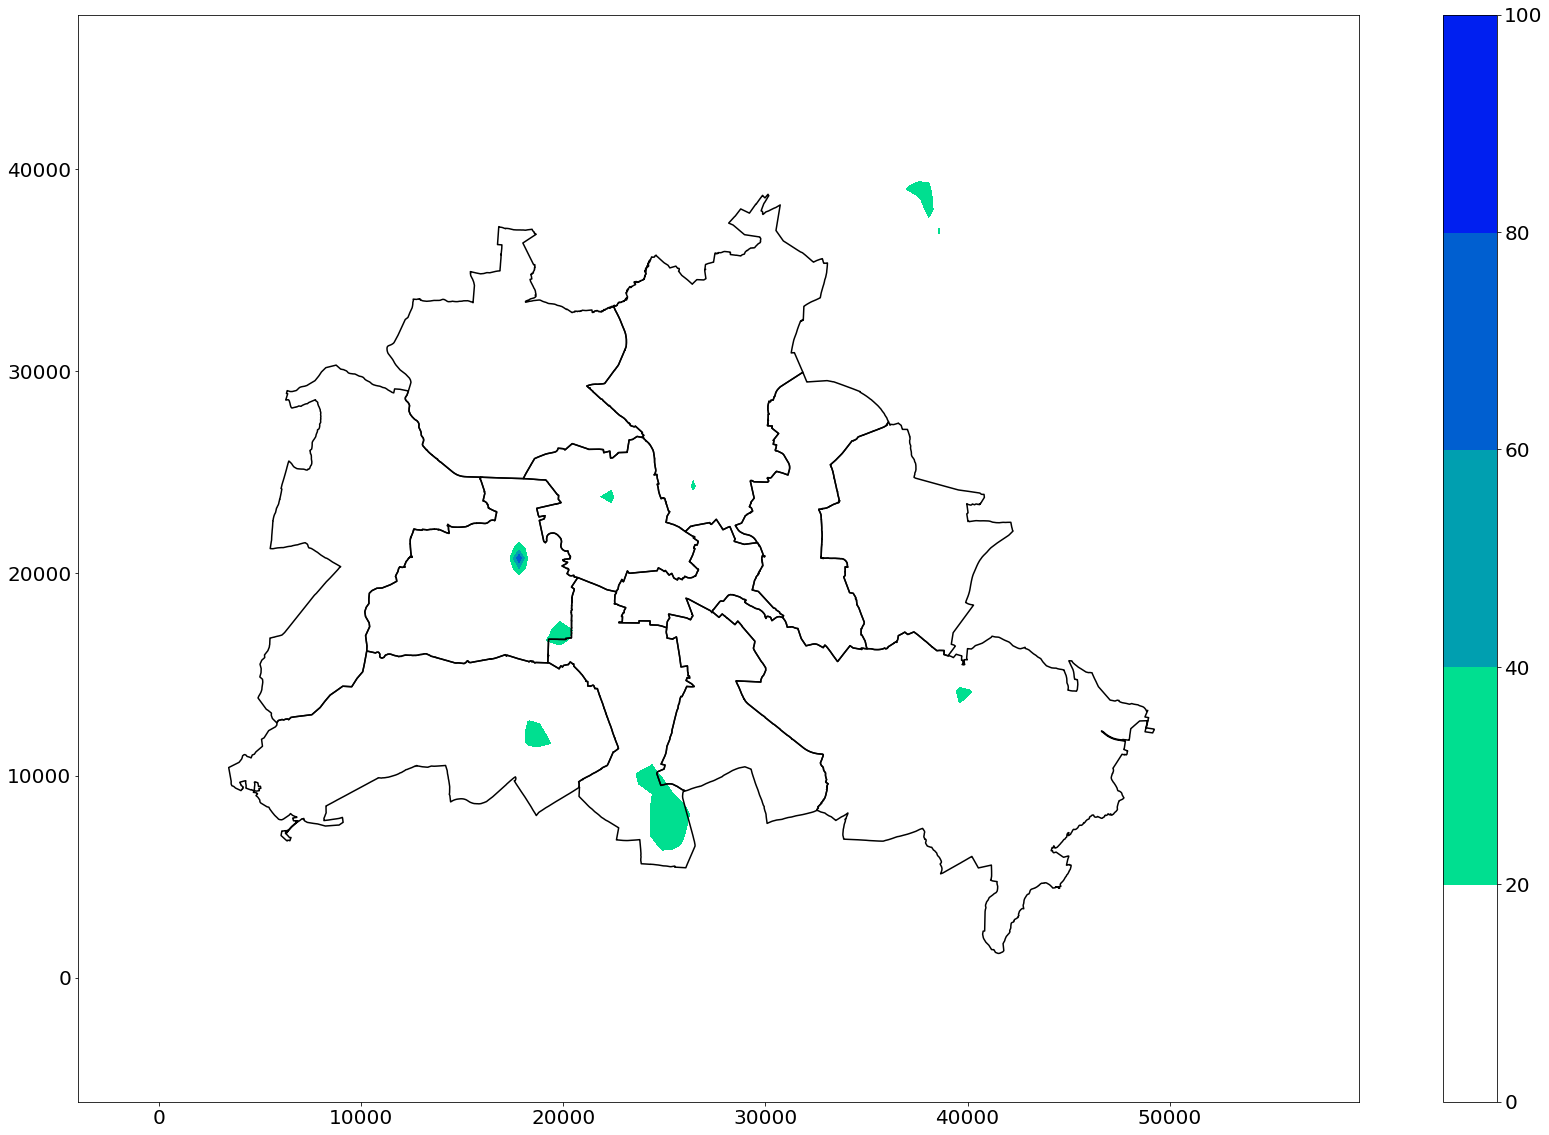

In [8]:
plt.rcParams["figure.figsize"] = 30, 20
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 50
plt.rcParams["axes.titlepad"] = 80

fig, ax = plt.subplots()

berlinDistricts.boundary.plot(ax=ax, edgecolor="black")

n_zones = 4
zones = np.linspace(0, 100, n_zones + 2)
plot = ax.contourf(xnew, ynew, interpolated_values, zones, cmap="winter_r")
plot.cmap.set_under('w')
plot.set_clim(zones[1])

# plot = ax.pcolormesh(xnew, ynew, interpolated_values)


fig.colorbar(plot, ax=ax)
# plt.show()

# plt.savefig("nn2.png")


In [ ]:
polygons = getPolygonsFromContour(plot)[1:] # skip first because it covers all areas with zones as holes
polygons = geopandas.GeoSeries(polygons)
polygons.crs = internal_crs
polygons = polygons.to_crs(external_crs)
polygons.to_file("test.geojson", driver="GeoJSON")